In [ ]:
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output, State
from jupyter_dash import JupyterDash
import plotly.graph_objects as go
import plotly.express as px
from dash import no_update


# Create a dash application
app = JupyterDash(__name__)
JupyterDash.infer_jupyter_proxy_config()

app.config.suppress_callback_exceptions = True

airline_data =  pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/airline_data.csv', 
                            encoding = "ISO-8859-1",
                            dtype={'Div1Airport': str, 'Div1TailNum': str, 
                                   'Div2Airport': str, 'Div2TailNum': str})

year_list = [i for i in range(2005, 2021, 1)]

def compute_data_choice_1(df):
    # Cancellation Category Count
    bar_data = df.groupby(['Month','CancellationCode'])['Flights'].sum().reset_index()
    # Average flight time by reporting airline
    line_data = df.groupby(['Month','Reporting_Airline'])['AirTime'].mean().reset_index()
    # Diverted Airport Landings
    div_data = df[df['DivAirportLandings'] != 0.0]
    # Source state count
    map_data = df.groupby(['OriginState'])['Flights'].sum().reset_index()
    # Destination state count
    tree_data = df.groupby(['DestState', 'Reporting_Airline'])['Flights'].sum().reset_index()
    return bar_data, line_data, div_data, map_data, tree_data

def compute_data_choice_2(df):
    # Compute delay averages
    avg_car = df.groupby(['Month','Reporting_Airline'])['CarrierDelay'].mean().reset_index()
    avg_weather = df.groupby(['Month','Reporting_Airline'])['WeatherDelay'].mean().reset_index()
    avg_NAS = df.groupby(['Month','Reporting_Airline'])['NASDelay'].mean().reset_index()
    avg_sec = df.groupby(['Month','Reporting_Airline'])['SecurityDelay'].mean().reset_index()
    avg_late = df.groupby(['Month','Reporting_Airline'])['LateAircraftDelay'].mean().reset_index()
    return avg_car, avg_weather, avg_NAS, avg_sec, avg_late


# Application layout
app.layout = html.Div(children=[ 
                              html.H2('US Domestic Airline Flights Performance',style={'textAlign':'center','color':'#503d36','font-size':25}),

                                html.Div([
                                    
                                    html.Div([
                                        
                                        html.Div(
                                            [
                                            html.H2('Report Type:', style={'margin-right': '2em'}),
                                            ]
                                        ),
                                        
                                        dcc.Dropdown(id='input-type',

options=[{'label': 'Yearly Airline performance', 'value':'OPT1'},{'label':'Yearly Airline Delay Report','value':'OPT2'}],
placeholder="Select a report type",
style={'width':'80%', 'padding':'3px', 'font-size': '20px', 'text-align-last' : 'center'}),
                                    
                                    ], style={'display':'flex'}),
                                    
                                   
                                   html.Div([
                                       
                                        html.Div(
                                            [
                                            html.H2('Choose Year:', style={'margin-right': '2em'})
                                            ]
                                        ),
                                        dcc.Dropdown(id='input-year', 
                                                     
                                                     options=[{'label': i, 'value': i} for i in year_list],
                                                     placeholder="Select a year",
                                                     style={'width':'80%', 'padding':'3px', 'font-size': '20px', 'text-align-last' : 'center'}),
                                            
                                            ], style={'display': 'flex'}),  
                                          ]),
                                
                                
                                html.Div([ ], id='plot1'),
    
                                html.Div([
                                        html.Div([ ], id='plot2'),
                                        html.Div([ ], id='plot3')
                                ], style={'display': 'flex'}),
                                
                                
                               html.Div([
                                    html.Div([ ], id='plot4'),
                                    html.Div([ ], id='plot5')
                            ], style={'display': 'flex'})
                           
                                ])


@app.callback([Output(component_id='plot1', component_property='children'),
Output(component_id='plot2', component_property='children'),
Output(component_id='plot3', component_property='children'),
Output(component_id='plot4', component_property='children'),
Output(component_id='plot5', component_property='children')],
[Input(component_id='input-type', component_property='value'),
Input(component_id='input-year', component_property='value')],
              [State("plot1", 'children'), State("plot2", "children"),
                State("plot3", "children"), State("plot4", "children"),
                State("plot5", "children")
               ])
def get_graph(chart, year, children1, children2, c3, c4, c5):
      
        df =  airline_data[airline_data['Year']==int(year)]
       
        if chart == 'OPT1':
            
            bar_data, line_data, div_data, map_data, tree_data = compute_data_choice_1(df)
            
            bar_fig = px.bar(bar_data, x='Month', y='Flights', color='CancellationCode', title='Monthly Flight Cancellation')

            line_fig = px.line(line_data, x='Month', y='AirTime', color='Reporting_Airline', title='Average monthly flight time(minutes) by airline')

            pie_fig = px.pie(div_data, values='Flights', names='Reporting_Airline', title='% of flights by reporting airline')

            map_fig = px.choropleth(map_data,  # Input data
                    locations='OriginState', 
                    color='Flights',  
                    hover_data=['OriginState', 'Flights'], 
                    locationmode = 'USA-states', # Set to plot as US States
                    color_continuous_scale='GnBu',
                    range_color=[0, map_data['Flights'].max()]) 
            map_fig.update_layout(
                    title_text = 'Number of flights from origin state', 
                    geo_scope='usa') # Plot only the USA instead of globe
            
            tree_fig = px.treemap(tree_data,path=['DestState', 'Reporting_Airline'],
                                  values='Flights',color='Flights',color_continuous_scale='RdBu',
                                  title='Flight count by airline to destination state')

            return [dcc.Graph(figure=tree_fig), 
                    dcc.Graph(figure=pie_fig),
                    dcc.Graph(figure=map_fig),
                    dcc.Graph(figure=bar_fig),
                    dcc.Graph(figure=line_fig)
                   ]
        else:
            avg_car, avg_weather, avg_NAS, avg_sec, avg_late = compute_data_choice_2(df)

            carrier_fig = px.line(avg_car, x='Month', y='CarrierDelay', color='Reporting_Airline', title='Average carrrier delay time (minutes) by airline')
            weather_fig = px.line(avg_weather, x='Month', y='WeatherDelay', color='Reporting_Airline', title='Average weather delay time (minutes) by airline')
            nas_fig = px.line(avg_NAS, x='Month', y='NASDelay', color='Reporting_Airline', title='Average NAS delay time (minutes) by airline')
            sec_fig = px.line(avg_sec, x='Month', y='SecurityDelay', color='Reporting_Airline', title='Average security delay time (minutes) by airline')
            late_fig = px.line(avg_late, x='Month', y='LateAircraftDelay', color='Reporting_Airline', title='Average late aircraft delay time (minutes) by airline')
            
            return[dcc.Graph(figure=carrier_fig), 
                   dcc.Graph(figure=weather_fig), 
                   dcc.Graph(figure=nas_fig), 
                   dcc.Graph(figure=sec_fig), 
                   dcc.Graph(figure=late_fig)]


# Run the app
if __name__ == '__main__':
    app.run_server(mode="inline", host="localhost", debug=False, dev_tools_ui=False, dev_tools_props_check=False)

## Input options

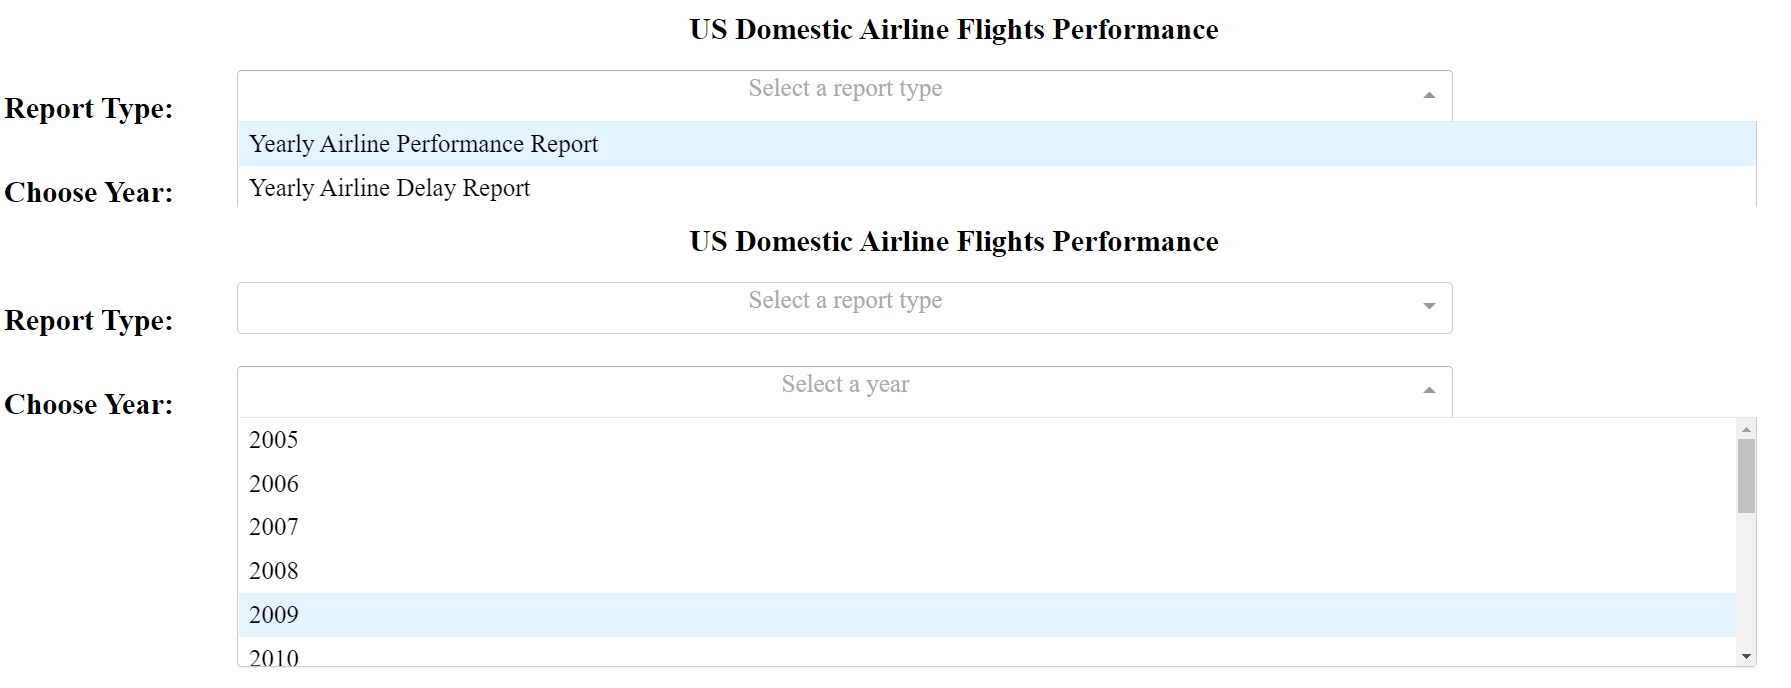

## Yearly airline delay report for 2010

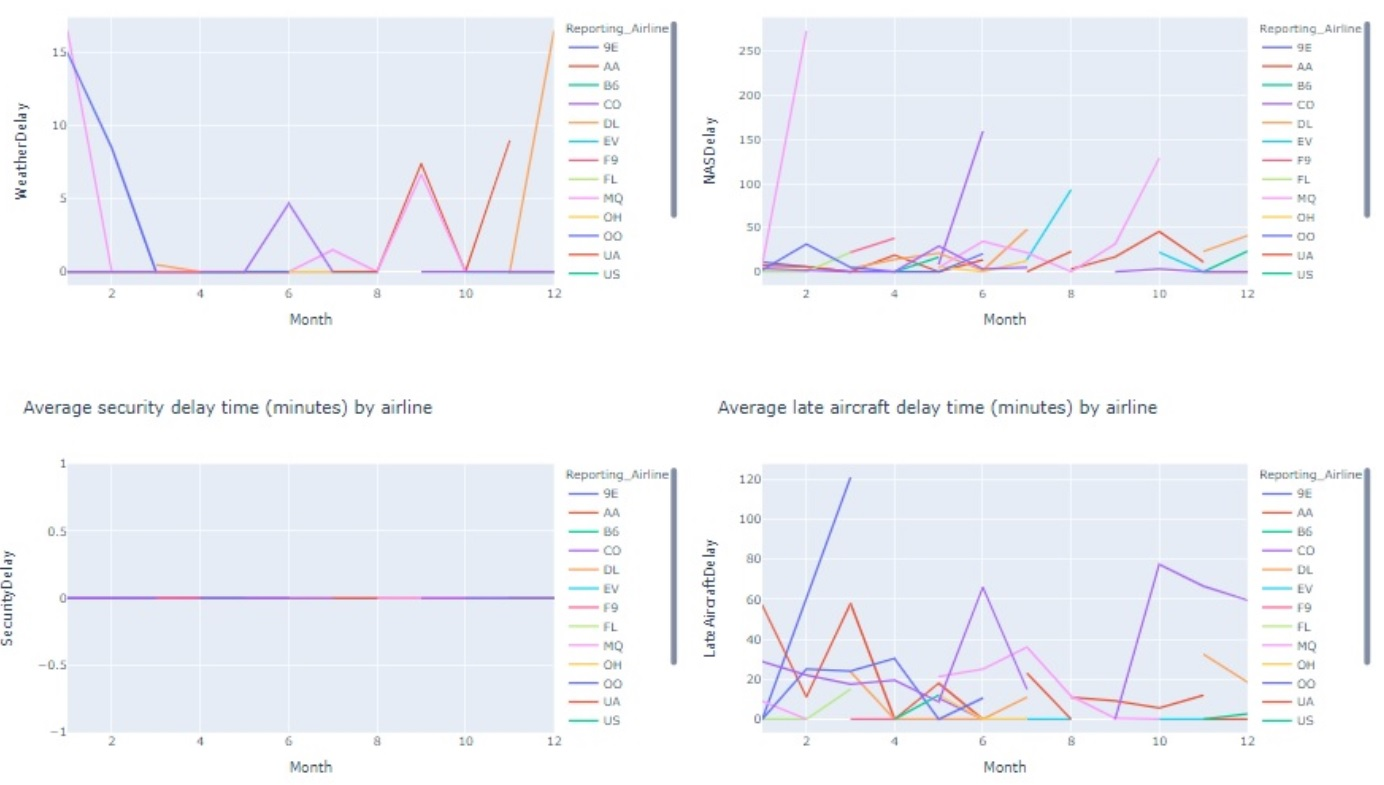

## Yearly airline performance report for 2005

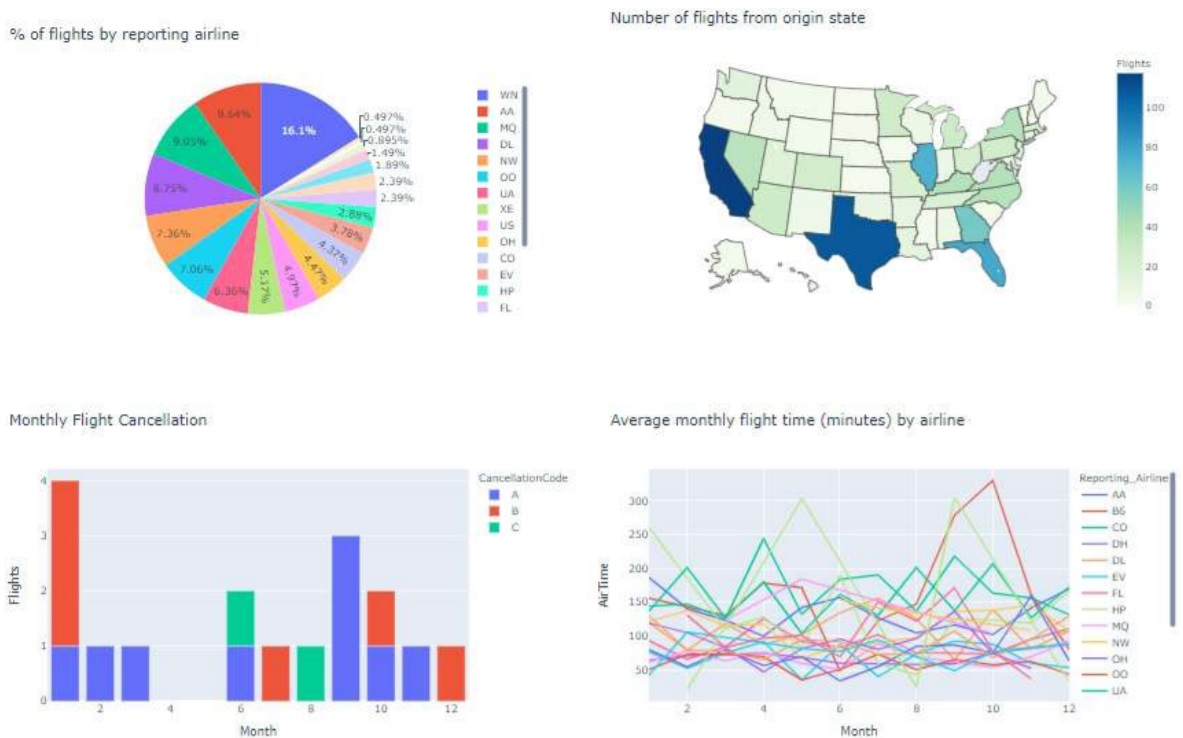

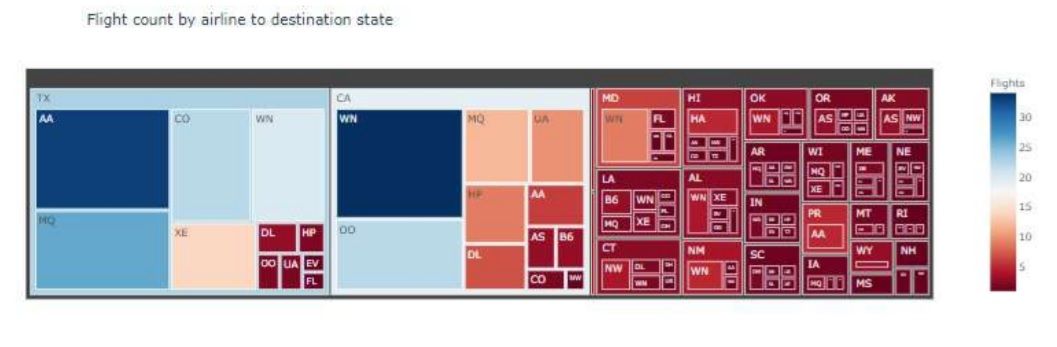